<a href="https://colab.research.google.com/github/wdavid93/OpenClassRoom/blob/main/test_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!ls

sample_data  spark-3.1.1-bin-hadoop3.2	spark-3.1.1-bin-hadoop3.2.tgz


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
!wget https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P8/fruits.zip

--2023-12-06 14:17:40--  https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P8/fruits.zip
Resolving s3.eu-west-1.amazonaws.com (s3.eu-west-1.amazonaws.com)... 52.218.118.0, 52.92.36.152, 52.218.41.235, ...
Connecting to s3.eu-west-1.amazonaws.com (s3.eu-west-1.amazonaws.com)|52.218.118.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1379678841 (1.3G) [application/zip]
Saving to: ‘fruits.zip’

fruits.zip          100%[===================>]   1.28G  16.6MB/s    in 82s     

2023-12-06 14:19:03 (16.0 MB/s) - ‘fruits.zip’ saved [1379678841/1379678841]



In [6]:
!unzip -q fruits.zip

In [7]:
!ls

fruits-360_dataset	  fruits.zip   spark-3.1.1-bin-hadoop3.2
fruits-360-original-size  sample_data  spark-3.1.1-bin-hadoop3.2.tgz


In [8]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.image import ImageSchema

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Charger les images
images_df = spark.read.format("image").load("fruits-360_dataset/fruits-360/Test/Apple Braeburn")

In [9]:
images_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [10]:
images_df.count()

164

In [11]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Chemin d'accès au répertoire des images
image_dir = "fruits-360_dataset/fruits-360/Test/Apple Braeburn"

# Vérifier si le répertoire existe
if os.path.exists(image_dir):
    # Charger les images
    images_df = spark.read.format("image").load(image_dir)
    # Afficher les premières lignes de images_df
    # images_df.show()
    print(f"Le répertoire {image_dir} existe.")
    # images_df.show()
else:
    print(f"Le répertoire {image_dir} n'existe pas.")


Le répertoire fruits-360_dataset/fruits-360/Test/Apple Braeburn existe.


In [12]:
!ls -l 'fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_4_100.jpg'


-rw-r--r-- 1 root root 5473 Sep 12  2021 'fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_4_100.jpg'


In [13]:
#import pyspark
import time
from pyspark import SQLContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.image import ImageSchema

from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
#import pyspark

def parse_categorie(path):
    '''Renvoie la catégorie d\'une image à partir de son chemin'''
    if len(path) > 0:
        #catégorie de l'image
        return path.split('/')[-2]
    else:
        return ''

def import_dossier(path):
    '''Renvoie un dataframe spark des images à partir du chemin du dossier.
    :param path: chemin vers le dossier
    :return: dataframe spark contenant toutes les images du dossier'''


def load_data(path_img):
    '''Chargement des dataframes:
    Prend en entrée le répertoire qui contient les sous répertoires contenant les images
    Renvoie en sortie un spark dataframe contenant les images et
    un spark dataframe contenant les noms des fruits associés'''
    #compteur
    start = time.time()
    #chargement dataframe des images

    df_img = spark.read.format("image").load(path) # ne fonctionne pas si il y a des espaces dans le chemin
    #df_img =  ImageSchema.readImages(path_img, dropImageFailures = True)
    print('chargement effectué')
    #récupération chemin à partir des images
    df_img = df_img.withColumn("path", input_file_name())
    #catégorisation des images
    udf_categorie = udf(parse_categorie, StringType())
    df_img = df_img.withColumn('categorie', udf_categorie('path'))
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))

    return df_img

In [14]:
#chargement du dataframe contenant les images, leur chemin et leur catégorie
path = "fruits-360_dataset/fruits-360/Test/Apple Braeburn"
spark_df = load_data(path)

chargement effectué
Temps de chargement des images : 00 secondes


In [15]:
spark_df.count()

164

In [16]:
import tensorflow as tf
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model

# Charger le modèle ResNet50 pré-entraîné sans la dernière couche de classification
# base_model = ResNet50(weights='imagenet', include_top=False)
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
# Chargement du modèle ResNet50 sans poids
model = ResNet50(weights=None)

# Fonction pour charger et prétraiter l'image
def preprocess_image(image_path):
    # Charger l'image
    img = load_img(image_path, target_size=(224, 224))
    # Convertir en tableau numpy
    img_array = img_to_array(img)
    # Ajouter une dimension pour créer un batch de taille 1
    img_batch = np.expand_dims(img_array, axis=0)
    # Prétraiter l'image pour le modèle ResNet50
    img_preprocessed = preprocess_input(img_batch)
    return img_preprocessed

# Fonction UDF pour appliquer le modèle à l'image et obtenir les caractéristiques
def extract_features(image_path):
    img_preprocessed = preprocess_image(image_path)
    features = model.predict(img_preprocessed)
    # Aplatir les caractéristiques en une liste pour les stocker dans une colonne DataFrame
    return features.flatten().tolist()

# Enregistrer la fonction UDF avec le type de retour approprié
extract_features_udf = udf(extract_features, ArrayType(FloatType()))

def preprocess_data(dataframe):
    '''Renvoie le résultat de l'avant dernière couche de chaque image du dataframe via le modèle ResNet50
    return un df contenant des vecteurs de dimension 1x2048 '''

    # Appliquer la fonction UDF pour extraire les caractéristiques
    output = dataframe.withColumn('image_preprocessed', extract_features_udf(col('path')))
    # Sélectionner les colonnes nécessaires
    output = output.select(['path', 'categorie', 'image_preprocessed'])
    return output


In [17]:
spark_df_preprocessed = preprocess_data(spark_df)

In [18]:
spark_df_preprocessed.count()

164

In [40]:
schema = spark_df_preprocessed.schema
schema

StructType(List(StructField(path,StringType,false),StructField(categorie,StringType,true),StructField(image_preprocessed,ArrayType(FloatType,true),true)))

In [23]:
# Sélectionner la colonne 'path' et afficher une seule ligne
spark_df_preprocessed.select('path').show(1)


+--------------------+
|                path|
+--------------------+
|file:///content/f...|
+--------------------+
only showing top 1 row



In [24]:
# Sélectionner la colonne 'categorie' et afficher une seule ligne
spark_df_preprocessed.select('categorie').show(1)


+----------------+
|       categorie|
+----------------+
|Apple%20Braeburn|
+----------------+
only showing top 1 row



In [63]:
# Sélectionner la colonne 'image_preprocessed' et afficher une seule ligne
# spark_df_preprocessed.select('image_preprocessed').show(10)

In [31]:
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate()

In [32]:
""" Return a JavaRDD of Object by unpickling
It will convert each Python object into Java object by Pyrolite, whenever the
RDD is serialized in batch or not.
"""

from pyspark.serializers import PickleSerializer, AutoBatchedSerializer

# Function to convert python object to Java objects
def _to_java_object_rdd(rdd):
    rdd = rdd._reserialize(AutoBatchedSerializer(PickleSerializer()))
    return rdd.ctx._jvm.org.apache.spark.mllib.api.python.SerDe.pythonToJava(rdd._jrdd, True)

# Convert DataFrame to an RDD
JavaObj = _to_java_object_rdd(images_df.rdd)

# Estimate size in bytes
nbytes = sc._jvm.org.apache.spark.util.SizeEstimator.estimate(JavaObj)
nbytes

118701192

In [52]:
schema = spark_df_preprocessed.schema
schema
# # Supposons que JavaObj est votre RDD Java
# # Convertir le RDD Java en DataFrame
# df = spark.createDataFrame(JavaObj, schema)

# # Afficher le DataFrame
# df.show()


# # Supposons que JavaObj est votre RDD Java
# # Convertir le RDD Java en RDD de tuples
# rdd = JavaObj.map(lambda x: tuple(x))

# # Créer le DataFrame à partir du RDD de tuples et du schéma
# df = spark.createDataFrame(rdd, schema)

# # Afficher le DataFrame
# df.show()

# # Supposons que JavaObj est votre objet Java
# java_object_list = JavaObj.get_data()  # Utilisez la méthode appropriée pour extraire les données

# # Convertir la liste en RDD
# rdd_from_java = sc.parallelize(java_object_list)

# # Convertir le RDD en DataFrame en utilisant le schéma
# df = spark.createDataFrame(rdd_from_java, schema)

# # Afficher le DataFrame
# df.show()


StructType(List(StructField(path,StringType,false),StructField(categorie,StringType,true),StructField(image_preprocessed,ArrayType(FloatType,true),true)))

In [68]:
from pyspark.ml.feature import PCA

# instantiate Spark PCA model
pca = PCA(k=8,
          inputCol="image_preprocessed",
          outputCol="pca_features")

In [59]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
# from pyspark.sql.types import VectorUDT

# # Définir une fonction UDF pour convertir array<float> en VectorUDT
# to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# # Appliquer la fonction UDF pour créer une nouvelle colonne de type VectorUDT
# spark_df_preprocessed = spark_df_preprocessed.withColumn("image_preprocessed_vector", to_vector_udf("image_preprocessed"))
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

# Définir une fonction UDF pour convertir array<float> en vecteur dense
to_vector_udf = udf(lambda arr: Vectors.dense(arr), ArrayType(FloatType()))

# Appliquer la fonction UDF pour créer une nouvelle colonne de type vecteur dense
spark_df_preprocessed = spark_df_preprocessed.withColumn("image_preprocessed_vector", to_vector_udf("image_preprocessed"))


In [65]:
spark_df_preprocessed

DataFrame[path: string, categorie: string, image_preprocessed: array<float>, image_preprocessed_vector: array<float>]

In [66]:
spark_df_preprocessed.select('image_preprocessed_vector')

DataFrame[image_preprocessed_vector: array<float>]

In [67]:
# fit the model on the extracted features
model = pca.fit(spark_df_preprocessed.select('image_preprocessed_vector'))

IllegalArgumentException: ignored

Image originale :


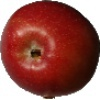

Image vectorisée :
[[255, 255, 253], [255, 255, 253], [254, 255, 255], [251, 255, 254], [251, 255, 255], [253, 254, 255], [254, 254, 255], [254, 252, 255], [255, 251, 253], [255, 252, 253], [255, 253, 254], [255, 253, 254], [254, 254, 254], [254, 254, 254], [254, 254, 255], [253, 254, 255], [248, 252, 255], [251, 255, 255], [255, 254, 255], [253, 249, 250], [255, 253, 255], [253, 249, 248], [254, 254, 252], [254, 255, 253], [249, 253, 252], [254, 255, 255], [252, 251, 255], [255, 253, 255], [253, 252, 255], [250, 251, 255], [249, 255, 255], [246, 254, 255], [251, 255, 255], [251, 252, 254], [254, 252, 253], [255, 254, 253], [255, 251, 252], [255, 250, 249], [255, 250, 250], [255, 247, 246], [255, 248, 246], [237, 211, 210], [136, 108, 105], [115, 87, 84], [89, 61, 57], [77, 49, 45], [88, 63, 58], [99, 74, 69], [110, 86, 82], [120, 99, 94], [133, 112, 107], [184, 167, 160], [255, 251, 246], [255, 251, 245], [255, 249, 245], [255, 253, 248], [255, 252, 250], [255, 251, 249], [255, 251, 2

In [71]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from PIL import Image
import numpy as np

# Initialiser une session Spark
spark = SparkSession.builder.appName("PCAExample").getOrCreate()

# Charger l'image
image = Image.open("fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_4_100.jpg")

# Convertir l'image en tableau numpy
image_array = np.array(image)

# Vectoriser l'image
vectorized_image = image_array.reshape((-1, 3)).tolist()

# Créer un DataFrame Spark à partir du tableau numpy
df = spark.createDataFrame([(Vectors.dense(x),) for x in vectorized_image], ["features"])

# Effectuer une analyse en composantes principales
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
transformed_image = model.transform(df).select("pca_features").rdd.flatMap(lambda x: x).collect()

# Afficher les résultats
print("Image originale :")
display(image)
print("Image vectorisée :")
print(vectorized_image)
print("Image transformée :")
print(transformed_image)

